In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, resnet34, resnet50
import torchvision.transforms as transforms
from torchsummary import summary

import numpy as np
import time
import pickle
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from medmnist import PathMNIST

from eqCLR.eq_resnet import EqResNet18, Mixed_EqResnet18
from eqCLR.test_resnet import Wide_ResNet
from evaluation import model_eval, dataset_to_X_y, lin_eval_rep

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2026-01-08 12:35:03.091869: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 12:35:03.164293: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-08 12:35:35.698397: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
class RandomRightAngleRotation:
    """Randomly rotate PIL image by 90, 180, or 270 degrees."""
    def __call__(self, x):
        angle = int(torch.randint(1, 4, ()).item()) * 90
        return x.rotate(angle)

In [5]:
# Simclr
with open('results/model_eval/2105-path_mnist-resnet18_with_maxpool_lr03_frac1.0_eval.pkl', 'rb') as f:
    eval_resnet18_100 = pickle.load(f)

with open('results/model_eval/2105-path_mnist-resnet18_with_maxpool_lr03_frac0.8_eval.pkl', 'rb') as f:
    eval_resnet18_80 = pickle.load(f)

with open('results/model_eval/2105-path_mnist-resnet18_with_maxpool_lr03_frac0.6_eval.pkl', 'rb') as f:
    eval_resnet18_60 = pickle.load(f)

with open('results/model_eval/2105-path_mnist-resnet18_with_maxpool_lr03_frac0.4_eval.pkl', 'rb') as f:
    eval_resnet18_40 = pickle.load(f)

with open('results/model_eval/2105-path_mnist-resnet18_with_maxpool_lr03_frac0.2_eval.pkl', 'rb') as f:
    eval_resnet18_20 = pickle.load(f)

In [22]:
with open('results/model_details/2105-path_mnist-resnet18_with_maxpool_lr03_frac1.0_details.pkl', 'rb') as f:
    details_resnet18_100 = pickle.load(f)

In [25]:
details_resnet18_100.keys()

dict_keys(['Filename', 'Model', 'N_EPOCHS', 'BATCH_SIZE', 'BASE_LR', 'WEIGHT_DECAY', 'MOMENTUM', 'CROP_LOW_SCALE', 'GRAYSCALE_PROB', 'PROJECTOR_HIDDEN_SIZE', 'PROJECTOR_OUTPUT_SIZE', 'Training augmentations', 'Training time', 'Training time per epoch', 'KNN during training', 'Image resize', 'Embeddings during training'])

In [26]:
details_resnet18_100

{'Filename': '2105-path_mnist-resnet18_with_maxpool_lr03',
 'Model': 'ResNetwithProjector(\n  (backbone): ResNet(\n    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\n    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n    (relu): ReLU(inplace=True)\n    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)\n    (layer1): Sequential(\n      (0): BasicBlock(\n        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)\n        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n        (relu): ReLU(inplace=True)\n        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)\n        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      )\n      (1): BasicBlock(\n        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [6]:
import pandas as pd

models = {
    "100%": eval_resnet18_100,
    "80%": eval_resnet18_80,
    "60%": eval_resnet18_60,
    "40%": eval_resnet18_40,
    "20%": eval_resnet18_20,
    }

eval_dict_all = {}

for model in models:
    eval_dict_all[model] = {}
    eval_dict = models[model]
    eval_dict_all[model]['KNN (k=10, euclidean)'] = eval_dict['euclidean'][10]
    eval_dict_all[model]['KNN (k=10, cosine)'] = eval_dict['cosine'][10]

    for key in eval_dict:
        if key != "cosine" and key != "euclidean" and key != 'linear_accuracy':
            eval_dict_all[model][key] = eval_dict[key]
    

evals_df_res = pd.DataFrame(eval_dict_all).T

display(evals_df_res)

,"KNN (k=10, euclidean)","KNN (k=10, cosine)",logistic_regression,linear_accuracy_rep,linear_accuracy_aug
100%,0.853343,0.853900,0.870334,0.868942,0.866435
80%,0.847214,0.846240,0.859889,0.857103,0.850557
60%,0.840529,0.839136,0.842758,0.842479,0.810446
40%,0.816435,0.816295,0.828830,0.827855,0.749164
20%,0.748468,0.748607,0.791086,0.794708,0.715181


In [8]:
# EqCLR
with open('results/model_eval/6253-path_mnist-eqCLR_N8_resize33_with_maxpool_frac1.0_eval.pkl', 'rb') as f:
    eval_eqresnet18_100 = pickle.load(f)

with open('results/model_eval/6253-path_mnist-eqCLR_N8_resize33_with_maxpool_frac0.8_eval.pkl', 'rb') as f:
    eval_eqresnet18_80 = pickle.load(f)

with open('results/model_eval/6253-path_mnist-eqCLR_N8_resize33_with_maxpool_frac_0.6_eval.pkl', 'rb') as f:
    eval_eqresnet18_60 = pickle.load(f)

with open('results/model_eval/6253-path_mnist-eqCLR_N8_resize33_with_maxpool_frac0.4_eval.pkl', 'rb') as f:
    eval_eqresnet18_40 = pickle.load(f)

with open('results/model_eval/6253-path_mnist-eqCLR_N8_resize33_with_maxpool_frac0.2_eval.pkl', 'rb') as f:
    eval_eqresnet18_20 = pickle.load(f)

In [9]:
import pandas as pd

models = {
    "100%": eval_eqresnet18_100,
    "80%": eval_eqresnet18_80,
    "60%": eval_eqresnet18_60,
    "40%": eval_eqresnet18_40,
    "20%": eval_eqresnet18_20,
    }

eval_dict_all = {}

for model in models:
    eval_dict_all[model] = {}
    eval_dict = models[model]
    eval_dict_all[model]['KNN (k=10, euclidean)'] = eval_dict['euclidean'][10]
    eval_dict_all[model]['KNN (k=10, cosine)'] = eval_dict['cosine'][10]

    for key in eval_dict:
        if key != "cosine" and key != "euclidean" and key != 'linear_accuracy':
            eval_dict_all[model][key] = eval_dict[key]
    

evals_df_eqres = pd.DataFrame(eval_dict_all).T

display(evals_df_eqres)

,"KNN (k=10, euclidean)","KNN (k=10, cosine)",logistic_regression,linear_accuracy_rep,linear_accuracy_aug
100%,0.900000,0.899443,0.910028,0.908774,0.909192
80%,0.896518,0.895265,0.914763,0.913928,0.911003
60%,0.886908,0.888022,0.900836,0.900696,0.887604
40%,0.875487,0.879666,0.891365,0.893036,0.878552
20%,0.855850,0.858217,0.867967,0.872423,0.841504


In [15]:
evals_df_eqres['KNN (k=10, euclidean)'].max()

0.9

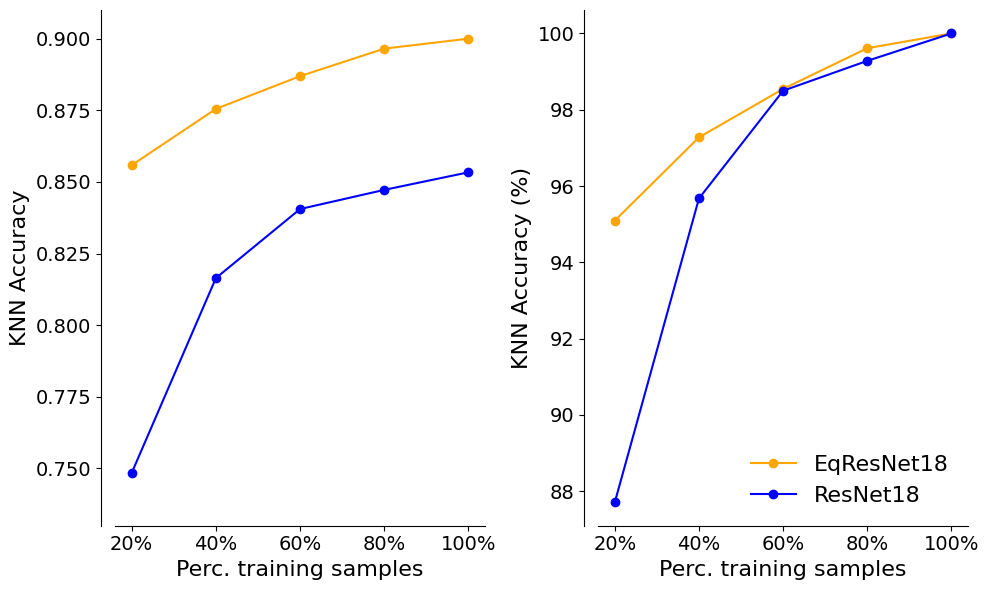

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
size = 16

ax[0].plot(evals_df_eqres.index[::-1], evals_df_eqres['KNN (k=10, euclidean)'][::-1], marker='o', label='EqResNet18', color='orange')
ax[0].plot(evals_df_res.index[::-1], evals_df_res['KNN (k=10, euclidean)'][::-1], marker='o', label='ResNet18', color='blue')

ax[0].set_ylim(0.73, 0.91)
ax[0].tick_params(axis='both', which='major', labelsize=size-2)
ax[0].spines['left'].set_position(('outward', 10)) 

ax[0].set_xlabel("Perc. training samples", fontsize=size)
ax[0].set_ylabel("KNN Accuracy", fontsize=size)
#ax[0].legend(frameon=False, loc='lower right', fontsize=size)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# KNN percentage difference plot
knn_eq = evals_df_eqres['KNN (k=10, euclidean)'] / evals_df_eqres['KNN (k=10, euclidean)'].max() * 100
knn_res = evals_df_res['KNN (k=10, euclidean)'] / evals_df_res['KNN (k=10, euclidean)'].max() * 100

ax[1].plot(evals_df_eqres.index[::-1], knn_eq[::-1], marker='o', label='EqResNet18', color='orange')
ax[1].plot(evals_df_res.index[::-1], knn_res[::-1], marker='o', label='ResNet18', color='blue')

#ax[1].set_ylim(0.73, 0.91)
ax[1].tick_params(axis='both', which='major', labelsize=size-2)
ax[1].spines['left'].set_position(('outward', 10)) 

ax[1].set_xlabel("Perc. training samples", fontsize=size)
ax[1].set_ylabel("KNN Accuracy (%)", fontsize=size)
ax[1].legend(frameon=False, loc='lower right', fontsize=size)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()

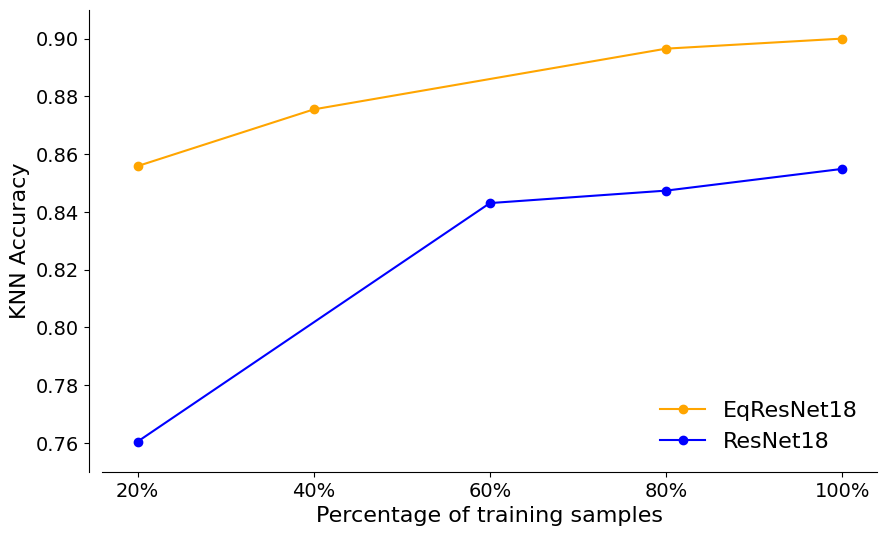

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
size = 16

x_vals = ['20%', '40%', '60%', '80%', '100%']
x_pos = list(range(len(x_vals)))

def plot_if_exists(df, label, color):
    xs = []
    ys = []

    for i, x in enumerate(x_vals):
        if x in df.index:
            xs.append(i)
            ys.append(df.loc[x, 'KNN (k=10, euclidean)'])

    ax.plot(xs, ys, marker='o', label=label, color=color)

plot_if_exists(evals_df_eqres, 'EqResNet18', 'orange')
plot_if_exists(evals_df_res, 'ResNet18', 'blue')

ax.set_xticks(x_pos)
ax.set_xticklabels(x_vals)

ax.set_ylim(0.75, 0.91)
ax.tick_params(axis='both', which='major', labelsize=size-2)
ax.spines['left'].set_position(('outward', 10)) 

ax.set_xlabel("Percentage of training samples", fontsize=size)
ax.set_ylabel("KNN Accuracy", fontsize=size)
ax.legend(frameon=False, loc='lower right', fontsize=size)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
